In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [36]:
# import the excel spreadsheets in the data folder
installer_df = pd.read_excel('../data/Installer.xlsx')
involver_df = pd.read_excel('../data/Involver.xlsx')

c:\Users\SyeAli\cs_projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\SyeAli\cs_projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [37]:
installer_df.shape

(32192, 49)

In [38]:
involver_df.shape

(31935, 49)

In [39]:
common_columns = installer_df.columns.intersection(involver_df.columns).tolist()
common_columns, len(common_columns)

(['Site',
  'Vessel_Name',
  'Wo_No',
  'Fault_Rep_Flag',
  'Pm_No',
  'Cf$_Pm_Interval',
  'Standard_Job',
  'Creation_Date',
  'Due_Date',
  'Actual_Finish',
  'Object_Id',
  'Object',
  'Maker_Name',
  'Group',
  'Object_Type',
  'Type',
  'Criticality',
  'Department',
  'Work_Type',
  'Running_Hour_Total',
  'Symptom',
  'Error_Cause',
  'Cause_Details',
  'Error_Class',
  'Discovery',
  'Performed_Action',
  'Total_Hours',
  'Total_Cost',
  'Used_Parts',
  'Used_Qty',
  'Returned_Parts',
  'Returned_Qty',
  'CaseReviewed',
  'EBSSelection',
  'EBSCode',
  'EBS1',
  'EBS2',
  'EBS3',
  'EBS4',
  'EBS5',
  'EBS6',
  'EBS7',
  'DamageType',
  'DamageDescriptor',
  'Directive',
  'Job_Description',
  'Work_Description',
  'Completion_Note',
  'Action_Taken'],
 49)

In [40]:
# Attempt to merge using a subset of key columns
merge_on_columns = ['Site', 'Vessel_Name', 'Wo_No']

df = pd.concat([installer_df, involver_df], axis=0)


In [41]:
df.shape

(64127, 49)

In [42]:
feature_columns = ['Group', 'Symptom', 'Error_Cause', 'Cause_Details', 'Error_Class', 'Discovery', 'Completion_Note', 'Action_Taken', 'Work_Description', 'Directive']
target_column = 'CaseReviewed'

In [43]:
# Filter the dataframe for the selected columns
df_filtered = df[feature_columns + [target_column]].dropna()

# Encode categorical variables
label_encoders = {}
for column in feature_columns:
    print(column)
    le = LabelEncoder()
    df_filtered[column] = le.fit_transform(df_filtered[column].astype(str))
    label_encoders[column] = le


Group
Symptom
Error_Cause
Cause_Details
Error_Class
Discovery
Completion_Note
Action_Taken
Work_Description
Directive


In [44]:

# Encode the target column
target_le = LabelEncoder()
df_filtered[target_column] = target_le.fit_transform(df_filtered[target_column].astype(str))

# Split the data into training and testing sets
X = df_filtered[feature_columns]
y = df_filtered[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [45]:

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
best_y_pred = best_rf_model.predict(X_test)

# Define common_classes based on unique classes in y_train and y_test
common_classes = list(set(y_train.unique()).intersection(set(y_test.unique())))
common_classes.sort()  # Ensure the classes are sorted for consistency


Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\SyeAli\cs_projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [46]:
# Evaluate the best model with the filtered common classes
best_accuracy = accuracy_score(y_test, best_y_pred)
best_report = classification_report(y_test, best_y_pred, labels=common_classes, target_names=target_le.inverse_transform(common_classes))

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy: 0.6521739130434783
Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.66      0.71        59
         1.0       0.65      0.62      0.64        24
           3       0.33      0.27      0.30        11
         3.1       0.61      0.75      0.67        44

   micro avg       0.66      0.65      0.65       138
   macro avg       0.59      0.58      0.58       138
weighted avg       0.66      0.65      0.65       138



<Axes: title={'center': 'Feature Importance'}>

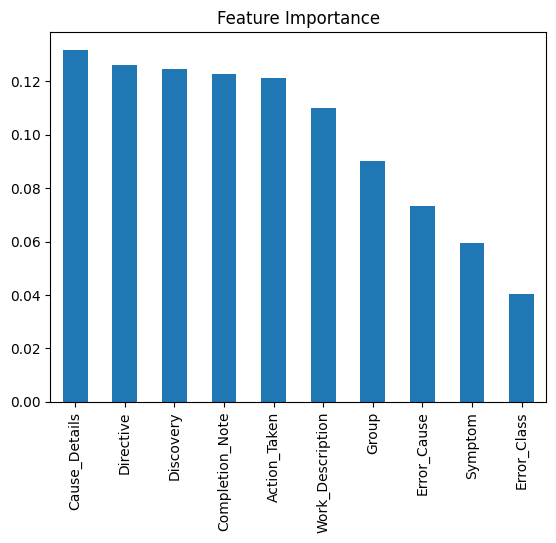

In [47]:
# visualize parameter importance
importances = best_rf_model.feature_importances_
importances_df = pd.DataFrame(importances, index=feature_columns, columns=['Importance'])
importances_df = importances_df.sort_values('Importance', ascending=False)
importances_df.plot(kind='bar', title='Feature Importance', legend=False)